# General data reader for AQUA 

AQUA is built on different python classes, the `Reader` one being the cornerstone in order to provide a centralized common data access point in order to develop diagnostics. 

AQUA `Reader` uses `intake` catalogues from NextGEMS data, plus other observational datasets. It has been tested and developed on Levante, but it is has been tested also on MN4 and Lumi. An FDB direct access is currently being developed, being transparent to the users.

On top of data access, the `Reader` includes also other functionalities: regridding, time and spatial averaging and metadata correction. Since streaming is not yet available, a streaming emulator has been introduced and can used to mimic streaming.

All these features can be used by the frontier diagnostics when they get real time data. Alternatively, some data have been included in the *Low Resolution Archive* (LRA), which is being built for each experiments and includes variable on monthly frequency, coarse grid and common metadata. State-of-the-art diagnostics can build on the LRA directly.

The idea of the regridder (which uses sparse matrix multiplication) is to generate first the weights for the interpolation (an operation which needs to be done only once) and then to use them for each regridding operation. For regridding to work you will need the external [smmregrid](https://github.com/jhardenberg/smmregrid) module in your environment.

The following notebooks illustrate more in detail different aspects of the functionality of the reader:

1. [Regridding](regrid.ipynb)
2. [Coordinate, variable name, units fixer](fixer.ipynb)
2. [Temporal averaging](timmean.ipynb)
3. [Spatial (field) averaging](fldmean.ipynb)
4. [Other datasets](datasets.ipynb)
5. [Streaming](streaming.ipynb)

## Basic functionality

In a nutshell, how to load ICON data, regrid them to a regular grid and plot a timeseries.

We start loading the module:

In [1]:
from aqua import Reader

FDB5 binary library not present on system, disabling FDB support.


Now let's load some ICON data. We first instantiate a `Reader` object specifying the type of data which we want to read from the catalogue. The `Reader` access is build on a 3-level hierarchy, made of `model`, `exp` and `source`. 
We also specify that we would like to regrid to a 0.1°x0.1° grid.
The first time (only then) when you run it, it will compute regridding weights for this particular source/destination grid combination. These will be stored in a directory specified in the `config/machines/<machine_name>/regrid.yaml` file. In this notebook we worked on levante, so the weights will be stored in `config/machines/levante/regrid.yaml`.

In [2]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid='r100')

Later  the actual data can be read with the `retrieve` method. We keep `fix=False` to access the data as they are. Please note that default is `fix=True`.

In [3]:
data = reader.retrieve(fix=False)

The reader returns an `xarray.Dataset` with raw ICON data on the original grid

In [4]:
data

<xarray.Dataset>
Dimensions:   (time: 37009, cell: 20971520)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
Dimensions without coordinates: cell
Data variables: (12/34)
    cfh_lnd   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    clivi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cllvi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cptgzvi   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfls      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfss      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ...        ...
    tas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauu      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauv      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ts        (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    uas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    vas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 152214
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

Let's inspect the "tas" variable (in a DataArray)

In [5]:
data.tas

<xarray.DataArray 'tas' (time: 37009, cell: 20971520)>
dask.array<open_dataset-tas, shape=(37009, 20971520), dtype=float32, chunksize=(6, 1048576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T00:30:00 ... 2022-03-01
Dimensions without coordinates: cell
Attributes:
    CDI_grid_type:                unstructured
    cell_methods:                 t: point
    height:                       2.0 m
    long_name:                    temperature in 2m
    number_of_grid_in_reference:  1
    param:                        0.0.0
    standard_name:                tas
    units:                        K

However, one of the possibility of the `Reader` is to have both ICON and IFS data on a common data format, namely grib-like, so that we can let `fix=True` and retrieve the data (please note that fixing will take care also of IFS cumulate fluxes)

In [6]:
data = reader.retrieve()

Notice that these data are still on the original (irregular) grid. We can regrid (part of) them with:

In [7]:
tasr = reader.regrid(data['2t'][10, :])
tasr

<xarray.DataArray '2t' (lat: 180, lon: 360)>
dask.array<reshape, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-01-20T05:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    cell_methods:                 t: point
    height:                       2.0 m
    long_name:                    2 metre temperature
    number_of_grid_in_reference:  1
    param:                        0.0.0
    standard_name:                tas
    units:                        K
    history:                      2023-06-12 00:44:45 variable renamed by AQU...
    paramId:                      167
    cfVarName:                    t2m
    shortName:                    2t
    regridded:                    1

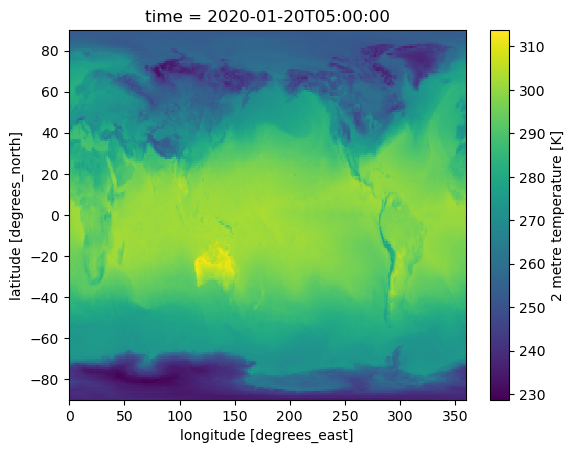

In [8]:
tasr.plot()

We can also plot a timeseries using the `fldmean` method.

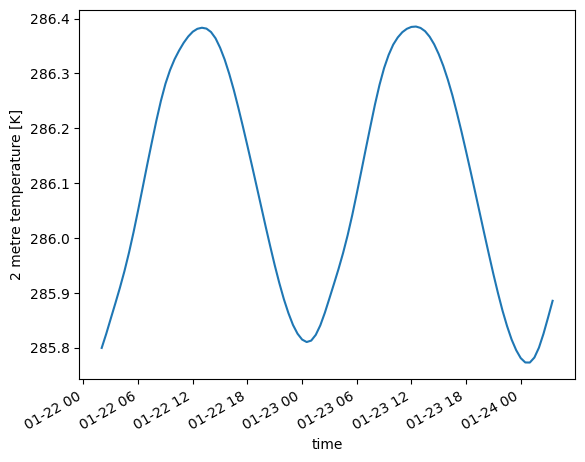

In [9]:
global_mean = reader.fldmean(data['2t'][100:200, :])
global_mean.plot()

Modifying the `Reader` 3-level hierarchy, we can also access directly data from the LRA, in this case below for FESOM.

In [13]:
reader = Reader(model="FESOM", exp="tco2559-ng5", source="lra-r100-monthly")
data = reader.retrieve(fix=False)
data

/home/b/b382075/mambaforge/envs/aqua/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/b/b382075/mambaforge/envs/aqua/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array

<xarray.Dataset>
Dimensions:  (time: 23, lat: 180, lon: 360, nz1: 69)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T02:00:00 ... 2020-12-01T02:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * nz1      (nz1) float64 2.5 7.5 12.5 17.5 ... 5.525e+03 5.825e+03 6.175e+03
Data variables:
    ci       (time, lat, lon) float64 dask.array<chunksize=(23, 180, 360), meta=np.ndarray>
    ocpt     (time, nz1, lat, lon) float64 dask.array<chunksize=(23, 69, 180, 360), meta=np.ndarray>
    sithick  (time, lat, lon) float64 dask.array<chunksize=(23, 180, 360), meta=np.ndarray>
    so       (time, nz1, lat, lon) float64 dask.array<chunksize=(23, 69, 180, 360), meta=np.ndarray>
    sos      (time, lat, lon) float64 dask.array<chunksize=(23, 180, 360), meta=np.ndarray>
    sst      (time, lat, lon) float64 dask.array<chunksize=(23, 180, 360), meta=np.ndarray>
    zos      (time, lat, lon) float64 dask.array<chunksize=(23, 180, 360), meta=np.ndarray>

We can easily plot the sst for February 2020

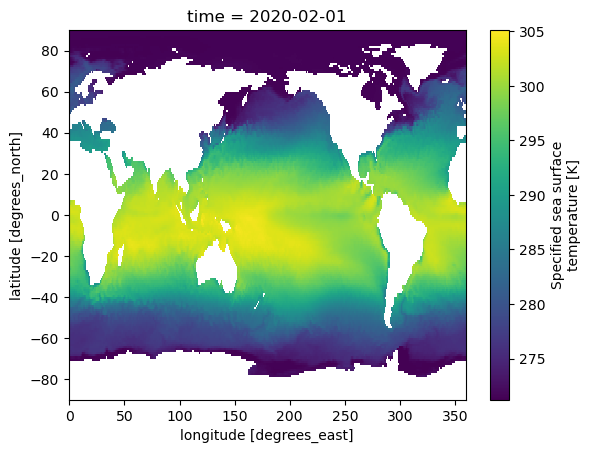

In [15]:
data['sst'][1,:,:].plot()

## Extra notes

### Dask

It is convenient to start a Dask cluster first (unless you already are working in a Levante jupyter notebook) and to connect to it

In [ ]:
from dask.distributed import LocalCluster, Client, progress
cluster = LocalCluster(ip="0.0.0.0", threads_per_worker=2, n_workers=16)
client = Client(cluster)  # memory_limit='64GB'
cluster

LocalCluster(ebce900c, 'tcp://136.172.124.3:37769', workers=16, threads=32, memory=503.45 GiB)

### Catalogue

In order to check what is available in the catalogue there is the `catalogue()` function. It returns the catalogue itself by default, that's why we use it with a semicolon at the end.

In [ ]:
from aqua import catalogue
catalogue();

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-mon	LRA monthly data 1x1 deg regular grid
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- lra-r100-mon	LRA monthly data 1x1 deg regular grid
IFS	test-tco2559	4km experiment, coupled with FESOM
	- ICMGG_atm2d	2d output
	- ICMU_atm3d	3d output
IFS	test-tco79	TCO79 test data
	- short	original 2d output
	- long	coarse IFS data 1y

FESOM	tco3999-ng5	2.5km experiment,

The data are classified in "models" (e.g. ICON, IFS etc.). Each model has a different "experiment" and there are different "sources" for each of them. 

A note on configuration files: by default the reader looks for its config files in a `config` folder in the current directory. If not found also the upper (`..`), the directory above it (`../..`), three directory up (`../../..`) and the a folder `.aqua/config` in the user's home are explored. In any case it is also possble to pass explicitly a `configdir` keyword to the catalogue and the to the reader.